# Demonstration of using Chemprop featurizer with DGL and PyTorch Geometric

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chemprop/chemprop/blob/main/examples/use_featurizer_with_other_libraries.ipynb)

In [ ]:
# Install chemprop from GitHub if running in Google Colab
import os

if os.getenv("COLAB_RELEASE_TAG"):
    try:
        import chemprop
    except ImportError:
        !git clone https://github.com/chemprop/chemprop.git
        %cd chemprop
        !pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0
        !pip install .
        !pip install  dgl -f https://data.dgl.ai/wheels/torch-2.4/repo.html
        !pip install torch_geometric
        %cd examples

# Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA
from pathlib import Path
import numpy as np

from chemprop import data, featurizers, models

### Load data

In [2]:
test_path = Path("..") / "tests" / "data" / "smis.csv"
smiles_column = "smiles"
df_test = pd.read_csv(test_path)

In [3]:
df_test = pd.read_csv(test_path)

smis = df_test[smiles_column]

test_data = [data.MoleculeDatapoint.from_smi(smi) for smi in smis]
test_data[:5]

[MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x7ec2273a1fc0>, y=None, weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14', V_f=None, E_f=None, V_d=None),
 MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x7ec2273a1ee0>, y=None, weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)CCc3ccccc23', V_f=None, E_f=None, V_d=None),
 MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x7ec2273a1e00>, y=None, weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl', V_f=None, E_f=None, V_d=None),
 MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x7ec2273a1d20>, y=None, weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(Cl)sc4[nH]3', V_f=None, E_f=None, V_d=None),
 MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x7ec2273a1c40

## Featurize molecules

In [4]:
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
molgraphs = [featurizer(data.mol) for data in test_data]

# Use Chemprop featurizer with DGL

In [5]:
# Install DGL separately if not already installed
# see https://www.dgl.ai/pages/start.html
import dgl
import networkx as nx

In [6]:
def convert_molgraph_to_dgl_graph(mg):
    """
    Takes a Chemprop molgraph from featurizer and converts it to a DGL graph object.
    Atom features are saved in 'n' and edge features in 'e'
    """
    # Instantiate a graph from the edges
    g = dgl.graph((mg.edge_index[0], mg.edge_index[1]), num_nodes=mg.V.shape[0])

    # Assign features
    g.ndata["n"] = torch.tensor(mg.V)
    g.edata["e"] = torch.tensor(mg.E)
    return g


def visualize_dgl_graph(g):
    """
    Visualize a DGL graph object.
    Adapted from https://docs.dgl.ai/en/0.2.x/tutorials/basics/1_first.html
    """
    nx_G = g.to_networkx()
    pos = nx.kamada_kawai_layout(nx_G)
    nx.draw(nx_G, pos, with_labels=True, node_color=[[0.5, 0.5, 0.5]])

In [7]:
# Convert the molgraphs to DGL graphs
gs = [convert_molgraph_to_dgl_graph(x) for x in molgraphs]

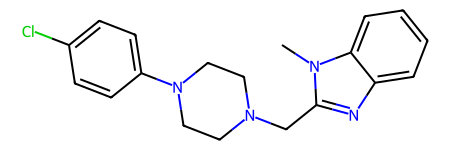

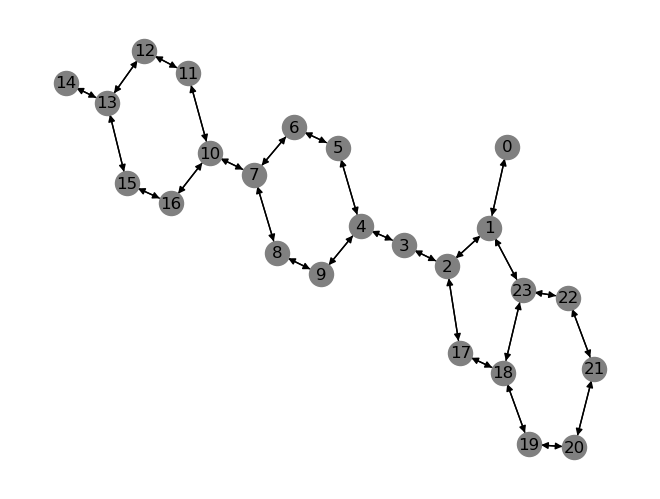

In [8]:
idx = 0  # Feel free to change this to visualize different graphs.

# Visualize the graphs
display(test_data[idx].mol)
visualize_dgl_graph(gs[idx])

In [9]:
# Examine the features
print(gs[idx].ndata)
print(gs[idx].edata)

{'n': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1201],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.1401],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.1201],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.1201],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.1201],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.1201]])}
{'e': tensor([[0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 

# Use Chemprop featurizer with PyTorch Geometric

In [10]:
# Install with https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html
import torch_geometric
from torch_geometric.data import Data
import networkx as nx

In [11]:
def convert_molgraph_to_pyg_graph(mg):
    """
    Takes a Chemprop molgraph from featurizer and converts it to a PyTorch Geometric graph.
    """
    # Instantiate a graph from the edges
    data = Data(edge_index=torch.from_numpy(mg.edge_index), x=mg.V, edge_attr=mg.E)
    return data


def visualize_pyg_graph(g):
    """
    Visualize a PyTorch Geometric graph object.
    """
    nx_G = torch_geometric.utils.to_networkx(g, to_undirected=False)
    pos = nx.kamada_kawai_layout(nx_G)
    nx.draw(nx_G, pos, with_labels=True, node_color=[[0.5, 0.5, 0.5]])

In [12]:
# Convert the molgraphs to PyG graphs
pygs = [convert_molgraph_to_pyg_graph(x) for x in molgraphs]

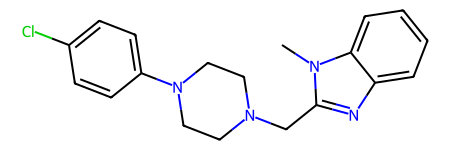

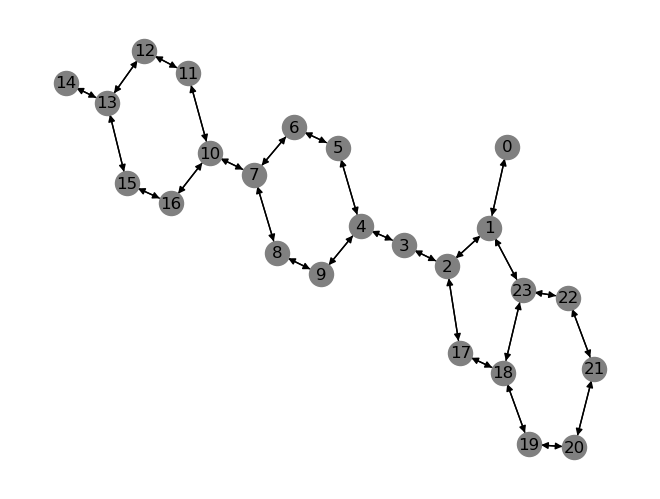

In [13]:
idx = 0  # Feel free to change this to visualize different graphs.

# Visualize the graphs
display(test_data[idx].mol)
visualize_pyg_graph(pygs[idx])

In [14]:
# Examine the features
print(pygs[idx].x)
print(pygs[idx].edge_attr)

[[0.      0.      0.      ... 0.      0.      0.12011]
 [0.      0.      0.      ... 0.      1.      0.14007]
 [0.      0.      0.      ... 0.      1.      0.12011]
 ...
 [0.      0.      0.      ... 0.      1.      0.12011]
 [0.      0.      0.      ... 0.      1.      0.12011]
 [0.      0.      0.      ... 0.      1.      0.12011]]
[[0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0.